# LSTM

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm

In [3]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].reshape(-1, 1), self.y[idx]

In [6]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,-0.321930,-0.294226,-0.289127,-0.309015,-0.301895,-0.295830,-0.287462,-0.258772,-0.235994,-0.190740,...,-0.358352,-0.354674,-0.347187,-0.336414,-0.347112,-0.351706,-0.302981,-0.305866,dengue,0
1,0.704151,0.701437,0.657708,0.620512,0.605176,0.577539,0.566426,0.553302,0.557018,0.586014,...,-0.705322,-0.706547,-0.702719,-0.710761,-0.730227,-0.743492,1.052168,1.038729,dengue,0
2,-0.600793,-0.611672,-0.641927,-0.703334,-0.735307,-0.768693,-0.800064,-0.804619,-0.820434,-0.815434,...,-0.569687,-0.576000,-0.578024,-0.579432,-0.603702,-0.614348,-0.570614,-0.585905,tuberculosis,3
3,0.247952,0.549077,0.506098,0.556442,0.566418,0.551450,0.540059,0.526959,0.543715,0.599491,...,-1.060635,-1.028392,-1.001280,-1.000335,-0.999817,-0.985046,-0.926241,-0.913381,tuberculosis,3
4,2.019074,1.994799,1.934128,1.892335,1.865262,1.841233,1.822519,1.801071,1.797511,1.823427,...,1.161945,1.144361,1.124002,1.120176,1.098351,1.037979,1.026160,0.998491,tuberculosis,3


In [7]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [9]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
INPUT_SIZE = 1
HIDDEN_SIZE = 64
OUTPUT_SIZE = 4
NUM_LAYERS = 3
SEQ_LENGTH = 1440

In [12]:
class Model(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE, num_layers=NUM_LAYERS):
        super(Model, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = x.to(DEVICE)

        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return self.softmax(out)

In [13]:
sample_x, sample_y = next(iter(train_loader))
sample_x.shape

torch.Size([8, 1440, 1])

## SGD

In [14]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [15]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─LSTM: 1-1                              [8, 1440, 64]             83,712
├─Linear: 1-2                            [8, 4]                    260
├─Softmax: 1-3                           [8, 4]                    --
Total params: 83,972
Trainable params: 83,972
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 964.36
Input size (MB): 0.05
Forward/backward pass size (MB): 5.90
Params size (MB): 0.34
Estimated Total Size (MB): 6.28

In [16]:
tb_board = RUNS_PATH + "lstm_sgd"
writer = SummaryWriter(tb_board)

In [17]:
writer.add_graph(model, sample_x)

In [18]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [20]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3842097918192546 - Accuracy: 0.3217391304347826 - Precision: 0.10351606805293004 - Recall: 0.3217391304347826 - F1: 0.1566361556064073
Epoch: 2 - Loss: 1.3840670029322306 - Accuracy: 0.3217391304347826 - Precision: 0.10351606805293004 - Recall: 0.3217391304347826 - F1: 0.1566361556064073
Epoch: 3 - Loss: 1.382992140452067 - Accuracy: 0.3217391304347826 - Precision: 0.10351606805293004 - Recall: 0.3217391304347826 - F1: 0.1566361556064073
Epoch: 4 - Loss: 1.384219717979431 - Accuracy: 0.3217391304347826 - Precision: 0.10351606805293004 - Recall: 0.3217391304347826 - F1: 0.1566361556064073
Epoch: 5 - Loss: 1.3836781183878581 - Accuracy: 0.3217391304347826 - Precision: 0.10351606805293004 - Recall: 0.3217391304347826 - F1: 0.1566361556064073
Epoch: 6 - Loss: 1.3840892473856607 - Accuracy: 0.3217391304347826 - Precision: 0.10351606805293004 - Recall: 0.3217391304347826 - F1: 0.1566361556064073
Epoch: 7 - Loss: 1.382862631479899 - Accuracy: 0.3217391304347826 - Precision:

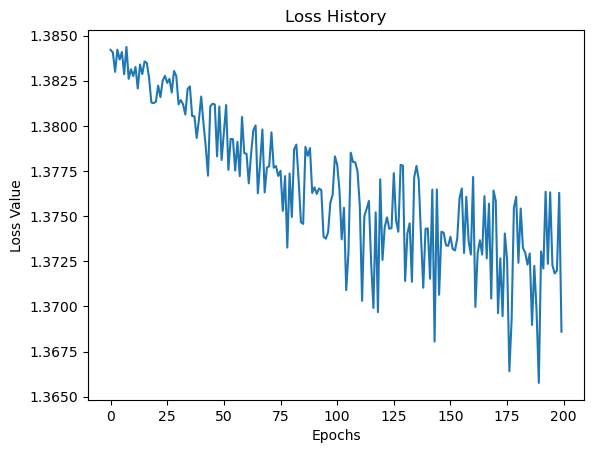

In [21]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_lstm.pdf", bbox_inches="tight")
plt.show()

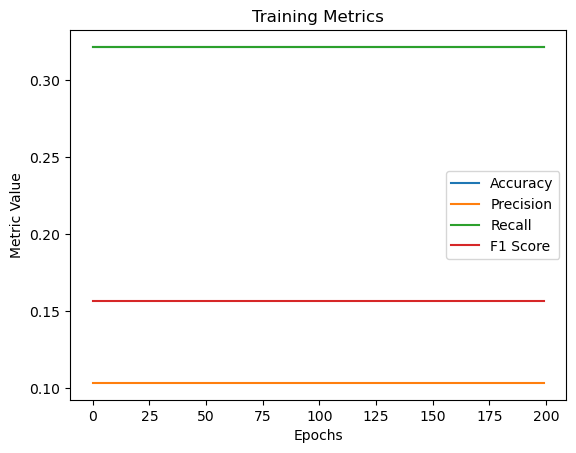

In [22]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_lstm.pdf", bbox_inches="tight")
plt.show()

In [23]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.3217391304347826
Mean Training Precision: 0.10351606805293007
Mean Training Recall: 0.3217391304347826
Mean Training F1 Score: 0.1566361556064073


In [24]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [25]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  num_samples, num_features = x.shape
  x = x.reshape(num_samples, num_features, 1)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [26]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.3672946691513062
Testing Accuracy: 0.3448275862068966
Testing Precision: 1.0
Testing Recall: 0.3448275862068966
Testing F1 Score: 0.5128205128205129


## Adam

In [ ]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─LSTM: 1-1                              [8, 1440, 64]             83,712
├─Linear: 1-2                            [8, 4]                    260
├─Softmax: 1-3                           [8, 4]                    --
Total params: 83,972
Trainable params: 83,972
Non-trainable params: 0
Total mult-adds (M): 964.36
Input size (MB): 0.05
Forward/backward pass size (MB): 5.90
Params size (MB): 0.34
Estimated Total Size (MB): 6.28

In [ ]:
tb_board = RUNS_PATH + "lstm_adam"
writer = SummaryWriter(tb_board)

In [ ]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.386770741144816 - Accuracy: 0.2782608695652174 - Precision: 0.07742911153119093 - Recall: 0.2782608695652174 - F1: 0.12114758947057085
Epoch: 2 - Loss: 1.3824264844258627 - Accuracy: 0.2782608695652174 - Precision: 0.07742911153119093 - Recall: 0.2782608695652174 - F1: 0.12114758947057085
Epoch: 3 - Loss: 1.3756152311960856 - Accuracy: 0.3565217391304348 - Precision: 0.2113637217691932 - Recall: 0.3565217391304348 - F1: 0.2516257496251874
Epoch: 4 - Loss: 1.3636672735214233 - Accuracy: 0.3391304347826087 - Precision: 0.11500945179584121 - Recall: 0.3391304347826087 - F1: 0.1717673630717109
Epoch: 5 - Loss: 1.3593482653299966 - Accuracy: 0.3391304347826087 - Precision: 0.11500945179584121 - Recall: 0.3391304347826087 - F1: 0.1717673630717109
Epoch: 6 - Loss: 1.3625900348027546 - Accuracy: 0.33043478260869563 - Precision: 0.19866220735785953 - Recall: 0.33043478260869563 - F1: 0.21302086545379792
Epoch: 7 - Loss: 1.3603582620620727 - Accuracy: 0.3391304347826087 - Prec

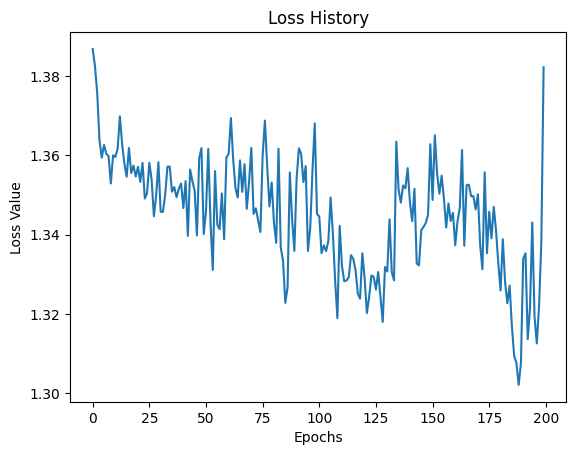

In [ ]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

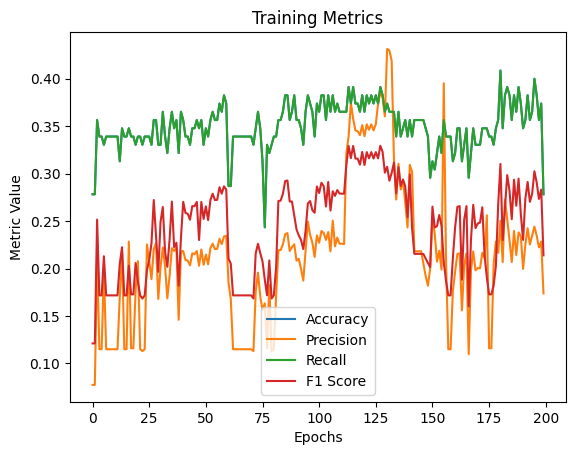

In [ ]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.show()

In [ ]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.35004347826086957
Mean Training Precision: 0.2160497567476763
Mean Training Recall: 0.35004347826086957
Mean Training F1 Score: 0.24274178411749822


In [ ]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [ ]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  num_samples, num_features = x.shape
  x = x.reshape(num_samples, num_features, 1)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [ ]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.460080862045288
Testing Accuracy: 0.20689655172413793
Testing Precision: 0.4551724137931034
Testing Recall: 0.20689655172413793
Testing F1 Score: 0.28352490421455934
